# グラフ彩色問題

Amplify を用いたグラフ彩色問題の解法について解説します。


## グラフ彩色問題の定式化


グラフ彩色問題とは、あるグラフが与えられたときに、与えられた制約条件の下でその頂点などに色を割り当てる問題です。最も典型的な問題は頂点に対して隣接する頂点同士別の色で塗り分ける問題です。

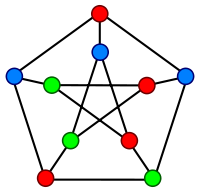

グラフ彩色問題にはいくつかの応用例が知られており、例えば、会議室・機械・タスクなどの割り当てに関するスケジューリング問題や、コンパイラによるレジスタ割り付け、携帯電話網における周波数割り当て等が挙げられます。今回は日本の都道府県に対して、4 色による塗り分けを行います。

各都道府県につき 4 つのバイナリ変数を用意し、そのうち 1 つだけを 1、それ以外を 0 とすることで、4 色のうちどの色で塗られているかを表現します。

| Region     | Red | Green | Blue | Yellow |
|----------- |-----|-------|------|--------|
| Hokkaido   | 0   | 0     | 1    | 0      |
| Aomori     | 0   | 1     | 0    | 0      |
| Akita      | 0   | 0     | 1    | 0      |
| Iwate      | 1   | 0     | 0    | 0      |

    
上記の例では北海道に青、青森に緑、秋田に青、岩手に赤を割り当てることを意味しています。上記の表の $i$ 行 $c$ 列にある変数を $q_{i,c}$ と表すことにします。このとき $q_{i, c}$ は $i$ 番目の都道府県を $c$ 番目の色で塗るかどうかを表します。必要な変数の数は領域数 $N$、 色数 $C$ に対して $NC$ となります。

塗り分け問題の定義から、以下が必要です。

* 一つの領域を一つの色で塗る
* 隣接する領域を同じ色で塗らない

これらは、バイナリ変数の間の制約条件として、以下のように書くことができます。

**制約条件**

$$
\begin{align}
    \sum_{c = 0}^{C-1}{ q_{i,c} } = 1 & \quad \text{for all} \; i \\
    q_{i,c} q_{j,c} = 0 & \quad \text{if Region} \; i \; \text{and Region} \; j \; \text{are adjacent}
\end{align}
$$

後でプログラムコード化する都合により、変数のインデックスは $0$ からスタートしていることに注意してください。


## 問題の作成

日本地図を扱うために Python の [japanmap](https://pypi.org/project/japanmap/) モジュールを使用します。都道府県コード ($1 \sim{} 47$) を用いて都道府県名や隣接情報などを取得できます。

まずは色の定義を行い、変数テーブルを用意します。都道府県コードとプログラムコード上のインデックスを合わせるために、ダミーの都道府県を用意し、$(47 + 1) \times 4$ 個のバイナリ変数を作成しておきます。

In [ ]:
from amplify import VariableGenerator
import japanmap as jm

colors = ["red", "green", "blue", "yellow"]
num_colors = len(colors)
num_region = len(jm.pref_names)

gen = VariableGenerator()
q = gen.array("Binary", shape=(num_region, num_colors))

次に制約条件を作成します。One-hot 制約は `amplify.one_hot` 関数、最小値0をとる制約については、 `amplify.equal_to` 関数を用いて次のように書けます。


In [ ]:
from amplify import sum as amplify_sum, one_hot, equal_to

# 各領域に対する制約
reg_constraints = one_hot(q[1:], axis=1)  # ダミー都道府県は定式化には含めない

# 隣接する領域間の制約
adj_constraints = amplify_sum(
    equal_to(q[i, :] * q[j, :], 0, axis=())
    for i in range(1, num_region)
    for j in jm.adjacent(
        i
    )  # j: 都道府県コード i の都道府県と隣接している都道府県コード
    if i < j  # type: ignore
)

model = reg_constraints + adj_constraints

隣接情報は `japanmap.adjacent` 関数に都道府県コードを入力すると隣接する都道府県コードを取得できます。


## イジングマシンの実行

イジングマシンのクライアントを作成しパラメータを設定し、以下のように定式化した問題を解きます。

In [ ]:
from amplify import AmplifyAEClient, solve
from datetime import timedelta

client = AmplifyAEClient()
client.parameters.time_limit_ms = timedelta(milliseconds=5000)  # タイムアウト 5000 ms
# client.token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"  # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください

# 求解と結果の取得
result = solve(model, client)
if len(result) == 0:
    raise RuntimeError("Some constraints are unsatisfied.")

### Note

もし ``result`` オブジェクトが空の場合、制約条件を満たす解が得られなかったことを意味します。この場合はイジングマシンのパラメータの変更が必要です。

## 結果の解析

以下のようにすることで、最良解における `q` の値を取得することができます。`q` の最初の列はダミー都道府県に関するバイナリ変数であり、定式化には含まれていなかったため、適当な値が入っています。

In [ ]:
q_values = q.evaluate(result.best.values)

q_values

結果を ``{都道府県名: 色}`` の形式に変換します。まずは ``q_values`` の各行のうち値が1のインデックスを取得します。その後、`japanmap.pref_names` を用いて都道府県名に変換し、対応する色を格納した辞書を作成します。


In [ ]:
import numpy as np

color_indices = (q_values[1:] @ np.arange(num_colors)).astype(
    int
)  # q_values の最初の行はダミー都道府県のものなので捨てる
color_map = {
    jm.pref_names[region_idx]: colors[color_idx]
    for region_idx, color_idx in enumerate(
        color_indices, start=1
    )  # region_idx は 1 スタートなことに注意
}

In [ ]:
color_map

最後に得られた塗り分けを表示します。次のようにしてプロットされます。

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 6, 6
plt.imshow(jm.picture(color_map))
plt.show()